(1) 데이터 가져오기

In [1]:
import pandas as pd

train = pd.read_csv("~/data/data/bike-sharing-demand/train.csv") 
train.info()
train.head()

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/data/data/bike-sharing-demand/train.csv'

(2)

datetime 컬럼을 datetime 자료형으로 변환하고 연, 월, 일, 시, 분, 초까지 6가지 컬럼 생성하기

season, weather one-hot incoding 하기

In [ ]:
train['datetime'] = pd.to_datetime(train['datetime'])
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second

train=pd.get_dummies(train, columns=['season', 'weather'])
train.info()
train.head()

(2-1) year, month, day, hour, minute, second 데이터 개수 시각화하기

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
cols = ['year', 'month', 'day', 'hour', 'minute', 'second']
for ax, col in zip(axs.flatten(), cols):
    sns.countplot(x=col, data=train, ax=ax)
    ax.set_title(f'Countplot of {col}')
plt.tight_layout()
plt.show()

(3) feature 재정의  
  
필요한 feature들만 재조립  
normalization  
  
(제외)  
예측할 목표값 이므로: count  
시간단위 count 이므로: minute, second  
가공했으므로 : datetime  
count에 포함되므로: casual, registered  
atemp와 temp는 상관관계가 높으므로: atemp  
데이터가 거의 없는 이상치: weather4

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler


train_features=train[['holiday','workingday','temp','atemp','humidity','windspeed','year','month','day','hour','season_1','season_2','season_3','season_4','weather_1','weather_2','weather_3']]
train_target=train[['count']]

# corr과 같은 shape의 mask 만들기
mask = np.triu(np.ones_like(train_features.corr(), dtype=bool))

plt.figure(figsize=(7,7))
plt.rcParams.update({'font.size': 7})
sns.heatmap(data = train_features.corr(), mask=mask, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

train_features=train[['holiday','workingday','temp','humidity','windspeed','year','month','day','hour','season_1','season_2','season_3','season_4','weather_1','weather_2','weather_3']]
#min-max
scaler = MinMaxScaler()
train_features=pd.DataFrame(scaler.fit_transform(train_features), columns=train_features.columns)

train_target=train[['count']]

NameError: name 'train' is not defined

(4) X, y 컬럼 선택 및 train/test 데이터 분리

In [5]:
from sklearn.model_selection import train_test_split

features_1  = ['year', 'month', 'day', 'hour', 'temp', 'humidity', 'windspeed']
features_all= ['holiday','workingday','temp','humidity','windspeed','year','month','day','hour','season_1','season_2','season_3','season_4','weather_1','weather_2','weather_3']
target=['count']

y = train_target[target]

X_1   = train[features_1];            X_train_1, X_test_1, y_train_1, y_test_1         = train_test_split(X_1  , y, test_size=0.2, random_state=42)
X_all = train_features[features_all]; X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.2, random_state=42)

y_train_1=y_train_1.squeeze()
y_train_all=y_train_all.squeeze()

(5) 모델 학습  
model_1 : 기본 문제에서 주어진 세팅, ['year', 'month', 'day', 'hour', 'temp', 'humidity', 'windspeed'], LinearRegression  
  
['holiday','workingday','temp','humidity','windspeed','year','month','day','hour','season_1','season_2','season_3','season_4','weather_1','weather_2','weather_3']  
입력값 normalization  
model_2 : LinearRegression  
model_3 : RandomForestRegressor  
model_4 : HistGradientBoostingRegressor  
model_5 : y_train log 변환, HistGradientBoostingRegressor  

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

model_1 = LinearRegression();   model_1.fit(X_train_1    , y_train_1)
model_2 = LinearRegression();   model_2.fit(X_train_all, y_train_all)

model_3 = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    min_samples_leaf=2,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)
model_3.fit(X_train_all    , y_train_all)

model_4 = HistGradientBoostingRegressor(
    max_iter=500,          # 트리 수 (충분히 크게)
    learning_rate=0.05,    # 보수적 러닝레이트
    max_depth=12,          # 적당한 깊이
    min_samples_leaf=20,   # 과적합 방지
    l2_regularization=0.0,
    early_stopping=True,   # 자동 조기 종료
    validation_fraction=0.1,
    random_state=42
)
model_4.fit(X_train_all    , y_train_all)

,loss,'squared_error'
,quantile,None
,learning_rate,0.05
,max_iter,500
,max_leaf_nodes,31
,max_depth,12
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'


(6) 학습된 모델로 X_test에 대한 예측값 출력 및 손실함수값 계산

In [7]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred_1   = model_1.predict(X_test_1);      mse = mean_squared_error(y_test_1, y_pred_1);      rmse = np.sqrt(mse)
print("model 1")
print("MSE:", mse)
print("RMSE:", rmse)
y_pred_2   = model_2.predict(X_test_all);    mse = mean_squared_error(y_test_all, y_pred_2);    rmse = np.sqrt(mse)
print("model 2")
print("MSE:", mse)
print("RMSE:", rmse)
y_pred_3   = model_3.predict(X_test_all);    mse = mean_squared_error(y_test_all, y_pred_3);    rmse = np.sqrt(mse)
print("model 3")
print("MSE:", mse)
print("RMSE:", rmse)
y_pred_4   = model_4.predict(X_test_all);    mse = mean_squared_error(y_test_all, y_pred_4);    rmse = np.sqrt(mse)
print("model 4")
print("MSE:", mse)
print("RMSE:", rmse)

model 1
MSE: 19961.901814435438
RMSE: 141.2865946027274
model 2
MSE: 19788.318409088864
RMSE: 140.6709579447331
model 3
MSE: 4489.8650581622105
RMSE: 67.00645534694557
model 4
MSE: 1608.9407262522236
RMSE: 40.11160338670375


(7) 출력값 분포 확인  
한쪽으로 너무 치우쳐있음
log scale 변환으로 해결

(array([105.,   0.,   0.,   0.,   0.,   0., 132.,   0.,   0.,   0.,   0.,
        144.,   0.,   0., 149.,   0.,   0., 169.,   0.,   0., 135.,   0.,
        118.,   0.,  99.,  83.,   0.,  95.,  95.,   0.,  76.,  65.,  66.,
         57.,  73.,  58.,  42.,  99.,  54.,  36.,  97.,  42.,  87.,  92.,
         82.,  80.,  75., 100.,  62.,  88.,  97.,  87.,  97.,  87., 104.,
        111., 110., 119., 147., 117., 119., 150., 160., 160., 166., 200.,
        194., 193., 221., 205., 226., 243., 268., 245., 247., 288., 277.,
        231., 242., 277., 261., 222., 236., 230., 226., 196., 189., 175.,
        162., 161., 122., 132.,  91.,  92.,  76.,  52.,  43.,  48.,  23.,
          6.]),
 array([0.69314718, 0.75507081, 0.81699443, 0.87891806, 0.94084168,
        1.00276531, 1.06468893, 1.12661255, 1.18853618, 1.2504598 ,
        1.31238343, 1.37430705, 1.43623068, 1.4981543 , 1.56007793,
        1.62200155, 1.68392518, 1.7458488 , 1.80777243, 1.86969605,
        1.93161968, 1.9935433 , 2.05546693, 2.

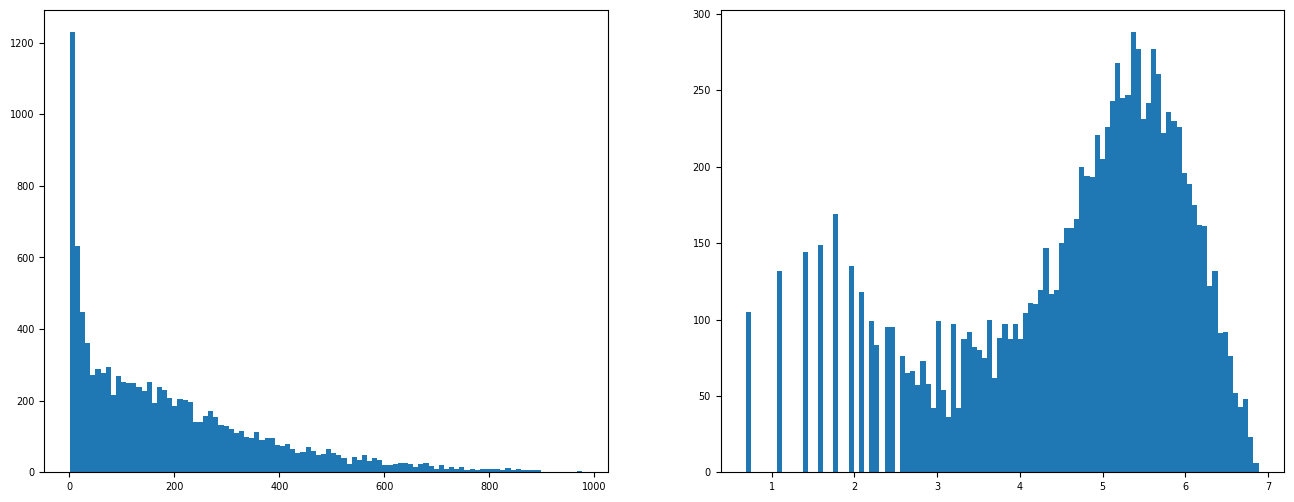

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].hist(y,bins=100)
axs[1].hist(np.log1p(y),bins=100)

(8) log scale output 으로 학습 후 예측값 출력 및 손실함수값 계산

In [9]:
y_log = np.log1p(y_train_all)
model_5 = HistGradientBoostingRegressor(
    max_iter=500,          # 트리 수 (충분히 크게)
    learning_rate=0.05,    # 보수적 러닝레이트
    max_depth=12,          # 적당한 깊이
    min_samples_leaf=20,   # 과적합 방지
    l2_regularization=0.0,
    early_stopping=True,   # 자동 조기 종료
    validation_fraction=0.1,
    random_state=42
)
model_5.fit(X_train_all    , y_log)

pred_log    = model_5.predict(X_test_all);
y_pred_5 = np.expm1(pred_log)         # 로그 역변환
y_pred_5 = np.clip(y_pred_5, 0, None)     # 음수 클립(안전)
mse = mean_squared_error(y_test_all, y_pred_5);      rmse = np.sqrt(mse)
print("model 5")
print("MSE:", mse)
print("RMSE:", rmse)

model 5
MSE: 1838.3112579490246
RMSE: 42.87553215936829


(9) log scale 적용 후 오히려 오차가 늘었음. log scale 적용하지 않은 모델로 최종 확정

In [10]:
model_4 = HistGradientBoostingRegressor(
    max_iter=500,          # 트리 수 (충분히 크게)
    learning_rate=0.05,    # 보수적 러닝레이트
    max_depth=12,          # 적당한 깊이
    min_samples_leaf=20,   # 과적합 방지
    l2_regularization=0.0,
    early_stopping=True,   # 자동 조기 종료
    validation_fraction=0.1,
    random_state=42
)
model_4.fit(X_train_all    , y_train_all)

y_pred_4   = model_4.predict(X_test_all);    mse = mean_squared_error(y_test_all, y_pred_4);    rmse = np.sqrt(mse)
print("model 4")
print("MSE:", mse)
print("RMSE:", rmse)

model 4
MSE: 1608.9407262522236
RMSE: 40.11160338670375


(10) x축은 temp 또는 humidity로, y축은 count로 예측 결과 시각화하기

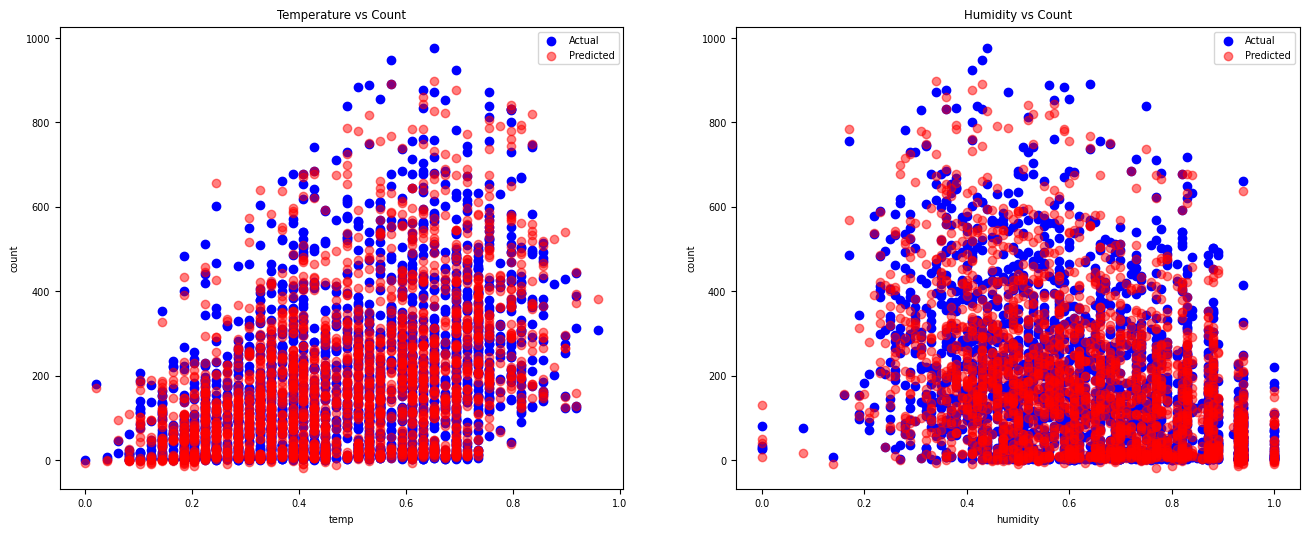

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# temp vs count 시각화
axs[0].scatter(X_test_all['temp'], y_test_all, color='blue', label='Actual')
axs[0].scatter(X_test_all['temp'], y_pred_4, color='red', label='Predicted', alpha=0.5)
axs[0].set_xlabel('temp')
axs[0].set_ylabel('count')
axs[0].set_title('Temperature vs Count')
axs[0].legend()

# humidity vs count 시각화
axs[1].scatter(X_test_all['humidity'], y_test_all, color='blue', label='Actual')
axs[1].scatter(X_test_all['humidity'], y_pred_4, color='red', label='Predicted', alpha=0.5)
axs[1].set_xlabel('humidity')
axs[1].set_ylabel('count')
axs[1].set_title('Humidity vs Count')
axs[1].legend()